# GraphRAG

In [1]:
import pandas as pd
import lancedb
from openai import AzureOpenAI
import dotenv
import os
from yfiles_jupyter_graphs import GraphWidget
from graphrag.query.indexer_adapters import read_indexer_entities, read_indexer_reports

from graphrag.query.structured_search.global_search.community_context import (
    GlobalCommunityContext,
)
from graphrag.query.structured_search.global_search.search import GlobalSearch

from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores.lancedb import LanceDBVectorStore

from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)

import numpy as np
import math

from graphrag.config.enums import ModelType
from graphrag.config.models.language_model_config import LanguageModelConfig
from graphrag.language_model.manager import ModelManager
import tiktoken

## Felhasznalt anyagok

https://github.com/ALucek/GraphRAG-Breakdown/blob/main/graph_examples.ipynb

graphrag init --root graphragtest

graphrag index --root graphragtest

https://microsoft.github.io/graphrag/index/default_dataflow/

https://folger-main-site-assets.s3.amazonaws.com/uploads/2022/11/romeo-and-juliet_TXT_FolgerShakespeare.txt

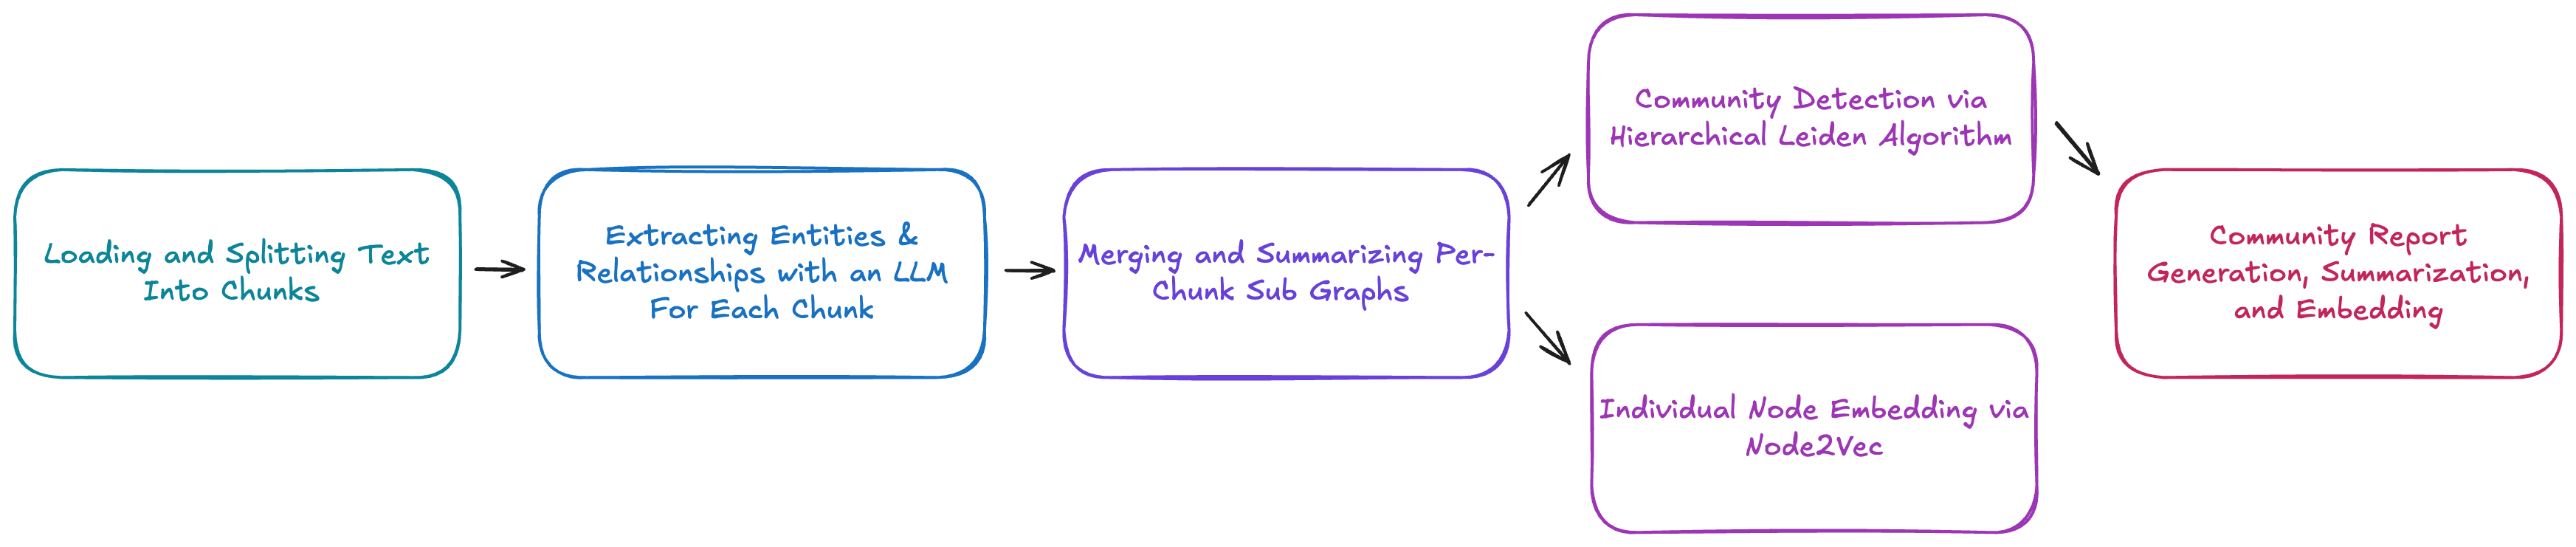

## Elokeszito kodok

In [2]:
dotenv.load_dotenv("graphragtest/.env")

True

In [3]:
chat_client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_API_BASE"),
    api_version=os.getenv("AZURE_API_VERSION"),
    api_key=os.getenv("AZURE_API_KEY")
)

In [4]:
embed_client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_API_BASE_EMBED"),
    api_version=os.getenv("AZURE_API_VERSION_EMBED"),
    api_key=os.getenv("AZURE_API_KEY_EMBED")
)

In [5]:
def get_embedding(text, model=os.getenv("AZURE_API_MODEL_EMBED")):
    response = embed_client.embeddings.create(
        input=text,
        model=model
    )
    return response.data[0].embedding

In [6]:
def get_chat_response(context, prompt, model=os.getenv("AZURE_API_MODEL")):
    response = chat_client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system", 
                "content": f"You are a helpful assistant answering questions based on context. \
                    Do not use any knowledge about Romeo and Julia that is not provided in the context. \
                    If the context is not sufficient, you must say 'I don't know'. \
                    Context: {context}"
            },
            {
                "role": "user", 
                "content": prompt
            }
        ]
    )
    return response.choices[0].message.content

In [7]:
def list_lancedb_tables():
    try:
        db = lancedb.connect("./graphragtest/output/lancedb")
        tables = db.table_names()
        print("Available tables:")
        for table in tables:
            print(f"  - {table}")
        return tables
    except Exception as e:
        print(f"Error listing tables: {e}")
        return []

In [8]:
def query_lancedb_vector(query_text, table_name, top_k=1):
    try:
        db = lancedb.connect("./graphragtest/output/lancedb")
        table = db.open_table(table_name)
        results = table.search(query_text).limit(top_k).to_pandas()
        return results
    except Exception as e:
        print(f"Error querying LanceDB: {e}")
        return None

In [9]:
def lancedb_rag(query, top_k=1):
    embedding = get_embedding(query)
    results1 = query_lancedb_vector(embedding, 'default-entity-description', top_k=top_k)
    results2 = query_lancedb_vector(embedding, 'default-text_unit-text', top_k=top_k)
    results3 = query_lancedb_vector(embedding, 'default-community-full_content', top_k=top_k)
    results = pd.concat([results1, results2, results3], ignore_index=True)

    if results is not None and not results.empty:
        context = results.text
        print(len(context))
        print("=" * 25, "LanceDB RAG Response", "=" * 25)
        print(context)
        print("=" * 50)
        response = get_chat_response(context, query)
    else:
        response = "No results found in LanceDB."
    return response

## LanceDB teszt - Hagyomanyos RAG

In [10]:
get_embedding('Who is Romeo\'s best friend?')

[-0.011136244051158428,
 -0.005623482633382082,
 -0.07020903378725052,
 0.0068530733697116375,
 -0.013577942736446857,
 -0.0379716195166111,
 0.012214320711791515,
 -0.010809906758368015,
 0.008409000933170319,
 -0.06279652565717697,
 -0.04927685856819153,
 0.0026514867786318064,
 -0.03668958321213722,
 0.014545298181474209,
 0.008409000933170319,
 -0.013601252809166908,
 -0.03130502626299858,
 0.009860034100711346,
 -0.017074408009648323,
 0.014790050685405731,
 0.015897264704108238,
 0.049743056297302246,
 0.035640642046928406,
 -0.027855178341269493,
 0.032260727137327194,
 -0.001281309057958424,
 -0.022214213386178017,
 -0.02878757007420063,
 -0.014102412387728691,
 0.027155885472893715,
 0.06428835541009903,
 -0.033239737153053284,
 0.053426001220941544,
 -0.023601144552230835,
 -0.026060326024889946,
 -0.026060326024889946,
 0.03566395118832588,
 -0.05100178346037865,
 0.01413737703114748,
 0.006445152219384909,
 0.00032597259269095957,
 -0.035011280328035355,
 -0.012855339795351

In [11]:
get_chat_response(None, 'Who is Romeo\'s best friend?')

"I don't know."

In [12]:
available_tables = list_lancedb_tables()

Available tables:
  - default-community-full_content
  - default-entity-description
  - default-text_unit-text


In [13]:
results = query_lancedb_vector(get_embedding('Who is Romeo\'s best friend?'), 'default-entity-description', top_k=5)
print(results.text)

0    ROMEO:Romeo is a young nobleman of Verona, the...
1    BENVOLIO:Benvolio is a Montague kinsman, nephe...
2    BALTHASAR:Balthasar is Romeo's servant and clo...
3    MONTAGUE FAMILY:The Montague family is one of ...
4    MERCUTIO:Mercutio is a witty, lively, and shar...
Name: text, dtype: object


In [14]:
get_chat_response(results.text, 'Who is Romeo\'s best friend?')

"I don't know."

In [15]:
results = query_lancedb_vector(get_embedding('Who is Romeo\'s best friend?'), 'default-community-full_content', top_k=5)
print(results.text)

0    # Romeo and the Montague-Capulet Feud\n\nThis ...
1    # Balthasar and the Second Watch in Verona\n\n...
2    # Romeo and the Montague-Capulet Feud Communit...
3    # Romeo, Households Montague and Capulet, and ...
4    # Benvolio, Mercutio, and the Verona Feud Netw...
Name: text, dtype: object


In [16]:
get_chat_response(results.text, 'Who is Romeo\'s best friend?')

"I don't know."

In [17]:
results = query_lancedb_vector(get_embedding('Who is Romeo\'s best friend?'), 'default-text_unit-text', top_k=5)
print(results.text)

0    row, father.\n\nFRIAR LAWRENCE  Benedicite.\nW...
1    She hath, and in that sparing makes huge waste...
2    Enter Romeo.]\n\n\nROMEO\nIf I may trust the f...
3    ALT\nWhy, uncle, 'tis a shame.\n\nCAPULET  Go ...
4     your mother?"\n\nNURSE  O God's lady dear,\nA...
Name: text, dtype: object


In [18]:
get_chat_response(results.text, 'Who is Romeo\'s best friend?')

"I don't know."

In [19]:
print(lancedb_rag('Who is Romeo\'s best friend?', top_k=3))

9
========================= LanceDB RAG Response =========================
0    ROMEO:Romeo is a young nobleman of Verona, the...
1    BENVOLIO:Benvolio is a Montague kinsman, nephe...
2    BALTHASAR:Balthasar is Romeo's servant and clo...
3    row, father.\n\nFRIAR LAWRENCE  Benedicite.\nW...
4    She hath, and in that sparing makes huge waste...
5    Enter Romeo.]\n\n\nROMEO\nIf I may trust the f...
6    # Romeo and the Montague-Capulet Feud\n\nThis ...
7    # Balthasar and the Second Watch in Verona\n\n...
8    # Romeo and the Montague-Capulet Feud Communit...
Name: text, dtype: object
The context does not explicitly state who Romeo's best friend is. Therefore, I don't know.


In [20]:
print(lancedb_rag('Who is Romeo\'s best friend?', top_k=5))

15
========================= LanceDB RAG Response =========================
0     ROMEO:Romeo is a young nobleman of Verona, the...
1     BENVOLIO:Benvolio is a Montague kinsman, nephe...
2     BALTHASAR:Balthasar is Romeo's servant and clo...
3     MONTAGUE FAMILY:The Montague family is one of ...
4     MERCUTIO:Mercutio is a witty, lively, and shar...
5     row, father.\n\nFRIAR LAWRENCE  Benedicite.\nW...
6     She hath, and in that sparing makes huge waste...
7     Enter Romeo.]\n\n\nROMEO\nIf I may trust the f...
8     ALT\nWhy, uncle, 'tis a shame.\n\nCAPULET  Go ...
9      your mother?"\n\nNURSE  O God's lady dear,\nA...
10    # Romeo and the Montague-Capulet Feud\n\nThis ...
11    # Balthasar and the Second Watch in Verona\n\n...
12    # Romeo and the Montague-Capulet Feud Communit...
13    # Romeo, Households Montague and Capulet, and ...
14    # Benvolio, Mercutio, and the Verona Feud Netw...
Name: text, dtype: object
The context does not explicitly state who Romeo's best fri

In [21]:
print(lancedb_rag('Who is Benvolio?', top_k=5))

15
========================= LanceDB RAG Response =========================
0     BENVOLIO:Benvolio is a Montague kinsman, nephe...
1     MERCUTIO:Mercutio is a witty, lively, and shar...
2     BALTHASAR:Balthasar is Romeo's servant and clo...
3     MONTAGUE FAMILY:The Montague family is one of ...
4     VALENTIO:Signior Valentio is a cousin of Tybal...
5     row, father.\n\nFRIAR LAWRENCE  Benedicite.\nW...
6     She hath, and in that sparing makes huge waste...
7      old ribbon?\nAnd yet thou wilt tutor me from ...
8      sir?\n\nSAMPSON  I do bite my thumb, sir.\n\n...
9      your mother?"\n\nNURSE  O God's lady dear,\nA...
10    # Benvolio, Mercutio, and the Verona Feud Netw...
11    # Capulet Family and Tybalt's Circle in Verona...
12    # Verona's Feuding Noble Families and the Prin...
13    # Balthasar and the Second Watch in Verona\n\n...
14    # Verona's Noble Families and Authority: Capul...
Name: text, dtype: object
Benvolio is a Montague kinsman, nephew of Montague.


In [22]:
print(lancedb_rag('Why the Capulets and Montague is fighting each other?', top_k=10))

30
========================= LanceDB RAG Response =========================
0     HOUSEHOLDS:The two feuding families, Montague ...
1     CAPULETS:The Capulets are a prominent and nobl...
2     MONTAGUES:The Montague family is a noble house...
3     MONTAGUE HOUSEHOLD:The Montague household is o...
4     HOUSE OF MONTAGUE:The House of Montague is the...
5     HOUSES:The Houses refer to the feuding Montagu...
6     MONTAGUE:Montague is the patriarch and head of...
7     MONTAGUE FAMILY:The Montague family is one of ...
8     CITIZENS:The citizens of Verona play a signifi...
9     CAPULET FAMILY:The Capulet family is a noble h...
10     sir?\n\nSAMPSON  I do bite my thumb, sir.\n\n...
11    Romeo and Juliet\nby William Shakespeare\nEdit...
12    .\n\nMERCUTIO\nHelp me into some house, Benvol...
13     your mother?"\n\nNURSE  O God's lady dear,\nA...
14    row, father.\n\nFRIAR LAWRENCE  Benedicite.\nW...
15     much bound to him.\n\nJULIET\nNurse, will you...
16     old ribbon?\nAnd yet 

In [23]:
print(print(lancedb_rag('List all the Capulet family members.', top_k=10)))

30
========================= LanceDB RAG Response =========================
0     CAPULET FAMILY:The Capulet family is a noble h...
1     HOUSE OF CAPULET:The House of Capulet is the n...
2     CAPULETS:The Capulets are a prominent and nobl...
3     CAPULET:Capulet is the patriarch and head of t...
4     MINE UNCLE CAPULET:Mine Uncle Capulet is a mal...
5     CAPULET'S HOUSE:Capulet's house is the locatio...
6     LADY CAPULET:Lady Capulet is a noblewoman in S...
7     HOUSE OF MONTAGUE:The House of Montague is the...
8     CAPELS:The Capels are Juliet's family, who hav...
9                                       FATHER CAPULET:
10     much bound to him.\n\nJULIET\nNurse, will you...
11     name,\nShot from the deadly level of a gun,\n...
12     sir?\n\nSAMPSON  I do bite my thumb, sir.\n\n...
13    , not a whit. What, I have watched ere now\nAl...
14     is 't that calls? It is my lady mother.\nIs s...
15    She hath, and in that sparing makes huge waste...
16     this place of peace?\

## Graf adatok vizsgalata

In [24]:
pd.read_parquet('./graphragtest/output/documents.parquet').head()

,id,human_readable_id,title,text,text_unit_ids,creation_date,metadata
0,e93a5dea8ae982ab8cb5ef802191dcc3bb4922d51875ef...,1,RomeoAndJuliet.txt,Romeo and Juliet\nby William Shakespeare\nEdit...,[d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a...,2025-07-26 17:50:03 +0200,None


In [25]:
pd.read_parquet('./graphragtest/output/entities.parquet').head()

,id,human_readable_id,title,type,description,text_unit_ids,frequency,degree,x,y
0,8e2dca85-587e-4171-be32-96767d74cb1c,0,ROMEO,PERSON,"Romeo is a young nobleman of Verona, the son o...",[d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a...,33,48,13.115127,14.289071
1,a297b1da-70aa-48fd-a64a-bc5d62cefe9b,1,JULIET,PERSON,Juliet is a central character in Shakespeare's...,[d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a...,23,54,13.837742,12.694275
2,ff30da27-781d-493c-9d92-04adc4dac770,2,WILLIAM SHAKESPEARE,PERSON,William Shakespeare is the author of the play ...,[d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a...,1,1,NaN,NaN
3,4aeb36cb-02ac-4c67-92fa-d5c8e133899c,3,BARBARA A. MOWAT,PERSON,Barbara A. Mowat is an editor of the version o...,[d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a...,1,1,NaN,NaN
4,326833d7-50a9-4958-895c-7848f749d825,4,PAUL WERSTINE,PERSON,"Paul Werstine is an editor of the version of ""...",[d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a...,1,1,NaN,NaN


In [26]:
pd.read_parquet('./graphragtest/output/relationships.parquet').head()

,id,human_readable_id,source,target,description,weight,combined_degree,text_unit_ids
0,07696552-ef05-4ed4-8b36-8dc8d01b928c,0,ROMEO,MONTAGUE,"Romeo is the son of Montague, the head of the ...",92.0,60,[d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a...
1,0af197b1-06fa-4baf-8934-c0aada39222f,1,ROMEO,LADY MONTAGUE,Lady Montague is Romeo's mother,9.0,51,[d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a...
2,70faf6dd-8363-44fe-b301-5478b199bcff,2,ROMEO,BALTHASAR,Balthasar is Romeo's loyal servant and attenda...,50.0,53,[d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a...
3,fcf7e278-0b31-4f73-8eb3-32cb8f94c3a7,3,ROMEO,MERCUTIO,Romeo and Mercutio are close friends and compa...,66.0,69,[d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a...
4,8ef38a08-eb23-4221-8480-205908d4a16b,4,ROMEO,FRIAR LAWRENCE,Friar Lawrence serves as a trusted religious f...,68.0,69,[d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a...


In [27]:
pd.read_parquet('./graphragtest/output/text_units.parquet').head()

,id,human_readable_id,text,n_tokens,document_ids,entity_ids,relationship_ids,covariate_ids
0,d194c0bc0a35bfe7253d75255e00a7cfb6bba3a6bac8a8...,1,Romeo and Juliet\nby William Shakespeare\nEdit...,1200,[e93a5dea8ae982ab8cb5ef802191dcc3bb4922d51875e...,"[8e2dca85-587e-4171-be32-96767d74cb1c, a297b1d...","[07696552-ef05-4ed4-8b36-8dc8d01b928c, 0af197b...",[]
1,825eac1d3e13ed9aff72ca8853e0e17b2f75f2382a94d8...,2,"sir?\n\nSAMPSON I do bite my thumb, sir.\n\n...",1200,[e93a5dea8ae982ab8cb5ef802191dcc3bb4922d51875e...,"[8e2dca85-587e-4171-be32-96767d74cb1c, fc7ee25...","[62c8b9d0-65fb-4e1e-bf6f-eea46928fea0, 2c327cc...",[]
2,cab03098d1a17d5e4234000fdc7fc36d2a34bff9040491...,3,"pursuing his,\nAnd gladly shunned who gladly ...",1200,[e93a5dea8ae982ab8cb5ef802191dcc3bb4922d51875e...,"[8e2dca85-587e-4171-be32-96767d74cb1c, 250701d...","[f1e631b8-5fc7-4d1a-80c9-b52c5cc7dfcb, 708f25c...",[]
3,55af20e48cfcfe1441d93b4bd95c1e870def3fddbd51ff...,4,"She hath, and in that sparing makes huge waste...",1200,[e93a5dea8ae982ab8cb5ef802191dcc3bb4922d51875e...,"[8e2dca85-587e-4171-be32-96767d74cb1c, fc7ee25...","[708f25c1-0c2c-4810-bcc3-e78631711862, f5773cb...",[]
4,5f9453a3730a2b2b21f91c4bfb25754a03621df67a4b55...,5,"utio and his brother Valentine,\nMine Uncle Ca...",1200,[e93a5dea8ae982ab8cb5ef802191dcc3bb4922d51875e...,"[8e2dca85-587e-4171-be32-96767d74cb1c, a297b1d...","[5f0eebd8-45fe-4fc5-b049-4471655fbd8b, bffdb9d...",[]


In [28]:
pd.read_parquet('./graphragtest/output/communities.parquet').head()

,id,human_readable_id,community,level,parent,children,title,entity_ids,relationship_ids,text_unit_ids,period,size
0,46d90444-384c-483c-a9cf-b218a0e3453b,0,0,0,-1,"[8, 9, 10]",Community 0,"[9cef1272-04a8-47e4-a505-9dcb25d5ee68, b7405db...","[00a10521-335d-4993-93d9-982e27d38b39, 07ab6a4...",[239d6a4248dce57bdab70dbd2732adf372082d248f89d...,2025-07-26,13
1,e014457c-e3ce-4988-b588-091cc66a0aca,1,1,0,-1,[],Community 1,"[a410684f-0b24-42e1-9e17-c304d6156732, 3979bdd...","[24ce02c2-0f23-4da7-8dad-3ed71632a872, 34c7f13...",[6fef61427f76b35d4e14994993322fd9f122904cd1412...,2025-07-26,10
2,0c774d42-d77c-4927-a7fa-513fc3fcb345,2,2,0,-1,"[11, 12, 13]",Community 2,"[a297b1da-70aa-48fd-a64a-bc5d62cefe9b, a6332e8...","[03b3a5f6-cd89-4746-9506-03d90085862a, 0fb9158...",[0e73ada9508a44c2fcb9022334abf0dbba4d8ac2822df...,2025-07-26,45
3,5602e981-49da-42b6-aa29-8149a6828813,3,3,0,-1,"[14, 15, 16]",Community 3,"[929e0244-3e2d-48bd-812e-c8f9255ca395, dff2f80...","[079e409b-6277-4d67-9f72-f30f97e434cc, 0acc6e9...",[55af20e48cfcfe1441d93b4bd95c1e870def3fddbd51f...,2025-07-26,22
4,0980f801-2199-42b3-9210-10f804495f8b,4,4,0,-1,[],Community 4,"[58b51bff-a184-426f-a4ce-bfdd386410be, 27af2f3...","[038c7efc-9d3d-47f8-84ab-1bfeabe9682f, 1c5e96c...",[d725860a588ea4338ef18836c83238e1507d0f0bed304...,2025-07-26,9


In [29]:
pd.read_parquet('./graphragtest/output/community_reports.parquet').head()

,id,human_readable_id,community,level,parent,children,title,summary,full_content,rank,rating_explanation,findings,full_content_json,period,size
0,4fb8bd7066814c9db8a3e51f5e288c36,30,30,3,27,[],Romeo and the Montague-Capulet Feud,"This community centers on Romeo, a young noble...",# Romeo and the Montague-Capulet Feud\n\nThis ...,8.5,The impact severity rating is high due to the ...,[{'explanation': 'Romeo is the primary entity ...,"{\n ""title"": ""Romeo and the Montague-Capule...",2025-07-26,18
1,cfbfc94e06b54964bb3029b7bdcddefa,31,31,3,27,[],Mantua Community: Romeo and the Apothecary,"This community centers on the city of Mantua, ...",# Mantua Community: Romeo and the Apothecary\n...,7.5,The impact severity rating is elevated due to ...,[{'explanation': 'Mantua serves as the city of...,"{\n ""title"": ""Mantua Community: Romeo and t...",2025-07-26,2
2,ae8f6f8038c1428281eb04a842ded422,23,23,2,11,[],House of Capulet: Lady Capulet and Juliet,This community centers on the House of Capulet...,# House of Capulet: Lady Capulet and Juliet\n\...,6.5,The impact severity rating reflects the signif...,[{'explanation': 'Lady Capulet is a central fi...,"{\n ""title"": ""House of Capulet: Lady Capule...",2025-07-26,2
3,4f250427575a44c6b058a7ff81b78eaa,24,24,2,11,[],Juliet and the Capulet Family Tragedy,"This community centers on Juliet, a young nobl...",# Juliet and the Capulet Family Tragedy\n\nThi...,8.5,The impact severity rating is high due to the ...,[{'explanation': 'Juliet is the pivotal entity...,"{\n ""title"": ""Juliet and the Capulet Family...",2025-07-26,29
4,f3cc909ce05540cb980816f339c3cf72,25,25,2,13,[],Capulet Family and Funeral Musicians,"This community centers on the Capulet family, ...",# Capulet Family and Funeral Musicians\n\nThis...,3.5,The impact severity rating is low to moderate ...,[{'explanation': 'The Capulet family is the pr...,"{\n ""title"": ""Capulet Family and Funeral Mu...",2025-07-26,4


## Command line hasznalata

In [30]:
!graphrag query --root ./graphragtest --method local --query "What is Tybalt's favourite food?"

2025-07-26 20:27:02.0991 - INFO - graphrag.storage.file_pipeline_storage - Creating file storage at /home/tothi/python/graphrag/graphragtest/output
2025-07-26 20:27:02.0992 - INFO - graphrag.utils.storage - reading table from storage: communities.parquet
2025-07-26 20:27:03.0025 - INFO - graphrag.utils.storage - reading table from storage: community_reports.parquet
2025-07-26 20:27:03.0071 - INFO - graphrag.utils.storage - reading table from storage: text_units.parquet
2025-07-26 20:27:03.0100 - INFO - graphrag.utils.storage - reading table from storage: relationships.parquet
2025-07-26 20:27:03.0115 - INFO - graphrag.utils.storage - reading table from storage: entities.parquet
2025-07-26 20:27:04.0053 - WARNING - graphrag.query.structured_search.local_search.mixed_context - Reached token limit - reverting to previous context state
2025-07-26 20:27:05.0658 - INFO - graphrag.cli.query - Local Search Response:
There is no information available in the provided data about Tybalt's favorite

In [31]:
!graphrag query --root ./graphragtest --method local --query "List all the Capulet family members."

2025-07-26 20:27:11.0388 - INFO - graphrag.storage.file_pipeline_storage - Creating file storage at /home/tothi/python/graphrag/graphragtest/output
2025-07-26 20:27:11.0389 - INFO - graphrag.utils.storage - reading table from storage: communities.parquet
2025-07-26 20:27:11.0425 - INFO - graphrag.utils.storage - reading table from storage: community_reports.parquet
2025-07-26 20:27:11.0471 - INFO - graphrag.utils.storage - reading table from storage: text_units.parquet
2025-07-26 20:27:11.0501 - INFO - graphrag.utils.storage - reading table from storage: relationships.parquet
2025-07-26 20:27:11.0516 - INFO - graphrag.utils.storage - reading table from storage: entities.parquet
2025-07-26 20:27:12.0403 - WARNING - graphrag.query.structured_search.local_search.mixed_context - Reached token limit - reverting to previous context state
2025-07-26 20:27:16.0907 - INFO - graphrag.cli.query - Local Search Response:
# Members of the Capulet Family

The Capulet family is a noble household in Ve

In [32]:
!graphrag query --root ./graphragtest --method global --query "List all the Capulet family members."

2025-07-26 20:27:22.0657 - INFO - graphrag.storage.file_pipeline_storage - Creating file storage at /home/tothi/python/graphrag/graphragtest/output
2025-07-26 20:27:22.0658 - INFO - graphrag.utils.storage - reading table from storage: entities.parquet
2025-07-26 20:27:22.0679 - INFO - graphrag.utils.storage - reading table from storage: communities.parquet
2025-07-26 20:27:22.0709 - INFO - graphrag.utils.storage - reading table from storage: community_reports.parquet
2025-07-26 20:27:39.0730 - INFO - graphrag.cli.query - Global Search Response:
The Capulet family is a noble household central to the narrative, comprising several key members and extended kin who play various roles within the family dynamics and the broader story.

### Core Family Members

- **Juliet Capulet**: The young noblewoman and central female figure of the Capulet family. Juliet's secret marriage to Romeo Montague is a pivotal element driving much of the narrative's conflict and tragedy. She faces significant fami

In [33]:
!graphrag query --root ./graphragtest --method local --query "Why the Capulets and Montague is fighting each other?"

2025-07-26 20:27:45.0449 - INFO - graphrag.storage.file_pipeline_storage - Creating file storage at /home/tothi/python/graphrag/graphragtest/output
2025-07-26 20:27:45.0450 - INFO - graphrag.utils.storage - reading table from storage: communities.parquet
2025-07-26 20:27:45.0483 - INFO - graphrag.utils.storage - reading table from storage: community_reports.parquet
2025-07-26 20:27:45.0530 - INFO - graphrag.utils.storage - reading table from storage: text_units.parquet
2025-07-26 20:27:45.0559 - INFO - graphrag.utils.storage - reading table from storage: relationships.parquet
2025-07-26 20:27:45.0576 - INFO - graphrag.utils.storage - reading table from storage: entities.parquet
2025-07-26 20:27:46.0438 - WARNING - graphrag.query.structured_search.local_search.mixed_context - Reached token limit - reverting to previous context state
2025-07-26 20:27:51.0115 - INFO - graphrag.cli.query - Local Search Response:
# The Feud Between the Capulets and Montagues

The Capulets and Montagues are 

In [34]:
!graphrag query --root ./graphragtest --method global --query "Why the Capulets and Montague is fighting each other?"

2025-07-26 20:27:56.0765 - INFO - graphrag.storage.file_pipeline_storage - Creating file storage at /home/tothi/python/graphrag/graphragtest/output
2025-07-26 20:27:56.0766 - INFO - graphrag.utils.storage - reading table from storage: entities.parquet
2025-07-26 20:27:56.0788 - INFO - graphrag.utils.storage - reading table from storage: communities.parquet
2025-07-26 20:27:56.0816 - INFO - graphrag.utils.storage - reading table from storage: community_reports.parquet
2025-07-26 20:28:31.0102 - INFO - graphrag.cli.query - Global Search Response:
The longstanding feud between the Capulet and Montague families is a deeply rooted conflict that drives much of the social and violent unrest in Verona. This bitter rivalry is primarily fueled by family loyalty, honor, and social rivalry, which have entrenched hostility between the two noble households over time. The feud affects not only the heads of the families but also their servants and the wider community, escalating tensions and leading t

## Elokeszito kodok

In [35]:
INPUT_DIR = "./graphragtest/output"
LANCEDB_URI = f"{INPUT_DIR}/lancedb"
COMMUNITY_REPORT_TABLE = "community_reports"
COMMUNITY_TABLE = "communities"
ENTITY_TABLE = "entities"
RELATIONSHIP_TABLE = "relationships"
COVARIATE_TABLE = "covariates"
TEXT_UNIT_TABLE = "text_units"
COMMUNITY_LEVEL = 2

In [36]:
api_key = os.environ["AZURE_API_KEY"]
llm_model = os.environ["AZURE_API_MODEL"]
emb_model = os.environ["AZURE_API_MODEL_EMBED"]
api_base=os.environ["AZURE_API_BASE"]
api_version=os.environ["AZURE_API_VERSION"]
emb_api_version=os.environ["AZURE_API_VERSION_EMBED"]
token_encoder = tiktoken.get_encoding('o200k_base')

In [37]:
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
community_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_TABLE}.parquet")
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")

entities = read_indexer_entities(entity_df, community_df, COMMUNITY_LEVEL)
relationships = read_indexer_relationships(relationship_df)
reports = read_indexer_reports(report_df, community_df, COMMUNITY_LEVEL)
text_units = read_indexer_text_units(text_unit_df)

description_embedding_store = LanceDBVectorStore(
    collection_name="default-entity-description",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)

In [38]:
# converts the entities dataframe to a list of dicts for yfiles-jupyter-graphs
def convert_entities_to_dicts(df):
    """Convert the entities dataframe to a list of dicts for yfiles-jupyter-graphs."""
    
    def clean_value(value):
        """Clean values to be JSON serializable."""
        if isinstance(value, np.ndarray):
            return value.tolist()
        elif isinstance(value, (np.floating, float)):
            if np.isnan(value) or np.isinf(value) or not math.isfinite(value):
                return 0.0  # Replace invalid floats with 0
            return float(value)
        elif isinstance(value, (np.integer, int)):
            return int(value)
        elif isinstance(value, list):
            return [clean_value(item) for item in value]
        elif hasattr(value, 'dtype'):  # Handle other numpy types
            return clean_value(value.item())
        elif isinstance(value, str):
            return str(value)
        else:
            return value
    
    nodes_dict = {}
    for _, row in df.iterrows():
        # Create a dictionary for each row and collect unique nodes
        node_id = str(row["title"])  # Ensure string
        if node_id not in nodes_dict:
            # Clean the properties to ensure JSON compatibility
            properties = {}
            for key, value in row.to_dict().items():
                try:
                    cleaned_value = clean_value(value)
                    properties[str(key)] = cleaned_value
                except Exception as e:
                    print(f"Warning: Could not clean value for key {key}: {value} - {e}")
                    properties[str(key)] = str(value)  # Fallback to string
            
            nodes_dict[node_id] = {
                "id": node_id,
                "properties": properties,
            }
    return list(nodes_dict.values())


# converts the relationships dataframe to a list of dicts for yfiles-jupyter-graphs
def convert_relationships_to_dicts(df):
    """Convert the relationships dataframe to a list of dicts for yfiles-jupyter-graphs."""
    
    def clean_value(value):
        """Clean values to be JSON serializable."""
        if isinstance(value, np.ndarray):
            return value.tolist()
        elif isinstance(value, (np.floating, float)):
            if np.isnan(value) or np.isinf(value) or not math.isfinite(value):
                return 0.0  # Replace invalid floats with 0
            return float(value)
        elif isinstance(value, (np.integer, int)):
            return int(value)
        elif isinstance(value, list):
            return [clean_value(item) for item in value]
        elif hasattr(value, 'dtype'):  # Handle other numpy types
            return clean_value(value.item())
        elif isinstance(value, str):
            return str(value)
        else:
            return value
    
    relationships = []
    for _, row in df.iterrows():
        # Create a dictionary for each row
        properties = {}
        for key, value in row.to_dict().items():
            try:
                cleaned_value = clean_value(value)
                properties[str(key)] = cleaned_value
            except Exception as e:
                print(f"Warning: Could not clean value for key {key}: {value} - {e}")
                properties[str(key)] = str(value)  # Fallback to string
            
        relationships.append({
            "start": str(row["source"]),
            "end": str(row["target"]),
            "properties": properties,
        })
    return relationships


# Check for problematic values before creating the widget
print("Checking entity_df for problematic values...")
for col in entity_df.columns:
    if entity_df[col].dtype in ['float64', 'float32']:
        invalid_count = entity_df[col].isnull().sum() + np.isinf(entity_df[col]).sum()
        if invalid_count > 0:
            print(f"Column {col} has {invalid_count} invalid values")

print("Checking relationship_df for problematic values...")
for col in relationship_df.columns:
    if relationship_df[col].dtype in ['float64', 'float32']:
        invalid_count = relationship_df[col].isnull().sum() + np.isinf(relationship_df[col]).sum()
        if invalid_count > 0:
            print(f"Column {col} has {invalid_count} invalid values")

w = GraphWidget()
w.directed = True
w.nodes = convert_entities_to_dicts(entity_df)
w.edges = convert_relationships_to_dicts(relationship_df)
print("GraphWidget created successfully!")

Checking entity_df for problematic values...
Column x has 22 invalid values
Column y has 22 invalid values
Checking relationship_df for problematic values...
GraphWidget created successfully!


In [39]:
# Add a simple community assignment based on entity type
type_to_community = {}
unique_types = entity_df['type'].unique()
for i, entity_type in enumerate(unique_types):
    type_to_community[entity_type] = i

# Add community information to entity data based on type
for node in w.nodes:
    entity_type = node['properties'].get('type', 'UNKNOWN')
    node['properties']['community'] = type_to_community.get(entity_type, 0)

# show title on the node
w.node_label_mapping = "title"

# map community to a color
def community_to_color(community):
    """Map a community to a color."""
    colors = [
        "crimson",
        "darkorange", 
        "indigo",
        "cornflowerblue",
        "cyan",
        "teal",
        "green",
        "purple",
        "brown",
        "pink"
    ]
    if community is None:
        return "lightgray"
    return colors[int(community) % len(colors)]

def edge_to_source_community(edge):
    """Get the community of the source node of an edge."""
    source_node = next(
        (entry for entry in w.nodes if entry["properties"]["title"] == edge["start"]),
        None,
    )
    if source_node and "community" in source_node["properties"]:
        source_node_community = source_node["properties"]["community"]
        return source_node_community
    return None

w.node_color_mapping = lambda node: community_to_color(node["properties"].get("community"))
w.edge_color_mapping = lambda edge: community_to_color(edge_to_source_community(edge))

# map size data to a reasonable factor - use degree since there's no 'size' in entity_df
w.node_scale_factor_mapping = lambda node: 0.5 + node["properties"].get("degree", 1) * 1.5 / 20

# use weight for edge thickness but make edges thinner by scaling down
w.edge_thickness_factor_mapping = lambda edge: edge["properties"].get("weight", 1) * 0.05

print(f"Assigned communities based on entity types:")
for entity_type, community in type_to_community.items():
    print(f"  {entity_type} -> Community {community}")
print(f"\nTotal entities: {len(w.nodes)}")
print(f"Total edges: {len(w.edges)}")

Assigned communities based on entity types:
  PERSON -> Community 0
  ORGANIZATION -> Community 1
  GEO -> Community 2
   -> Community 3
  EVENT -> Community 4

Total entities: 178
Total edges: 350


## Graf vizualizacio

In [40]:
display(w)

GraphWidget(layout=Layout(height='800px', width='100%'))

## Elokeszito kodok

In [41]:
chat_config = LanguageModelConfig(
    api_key=api_key,
    api_base=api_base,
    api_version=api_version,
    deployment_name=llm_model,
    type=ModelType.AzureOpenAIChat,
    encoding_model='o200k_base',
    model=llm_model,
    max_retries=20,
)

chat_model = ModelManager().get_or_create_chat_model(
    name="local_search",
    model_type=ModelType.AzureOpenAIChat,
    config=chat_config,
)

In [42]:
embedding_config = LanguageModelConfig(
    api_key=api_key,
    api_base=api_base,
    api_version=emb_api_version,
    deployment_name=emb_model,
    type=ModelType.AzureOpenAIEmbedding,
    model=emb_model,
    max_retries=20,
)

text_embedder = ModelManager().get_or_create_embedding_model(
    name="local_search_embedding",
    model_type=ModelType.AzureOpenAIEmbedding,
    config=embedding_config,
)

In [43]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  # if the vectorstore uses entity title as ids, set this to EntityVectorStoreKey.TITLE
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  # set this to EntityVectorStoreKey.TITLE if the vectorstore uses entity title as ids
    "max_tokens": 24_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
}

llm_params = {
    "max_tokens": 8_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000=1500)
    "temperature": 0.0,
}

search_engine = LocalSearch(
    model=chat_model,
    context_builder=context_builder,
    token_encoder=token_encoder,
    model_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

In [44]:
"""
Helper function to visualize the result context with `yfiles-jupyter-graphs`.

The dataframes are converted into supported nodes and relationships lists and then passed to yfiles-jupyter-graphs.
Additionally, some values are mapped to visualization properties.
"""


def show_graph(result):
    """Visualize the result context with yfiles-jupyter-graphs."""
    from yfiles_jupyter_graphs import GraphWidget

    if (
        "entities" not in result.context_data
        or "relationships" not in result.context_data
    ):
        msg = "The passed results do not contain 'entities' or 'relationships'"
        raise ValueError(msg)

    # converts the entities dataframe to a list of dicts for yfiles-jupyter-graphs
    def convert_entities_to_dicts(df):
        """Convert the entities dataframe to a list of dicts for yfiles-jupyter-graphs."""
        nodes_dict = {}
        for _, row in df.iterrows():
            # Create a dictionary for each row and collect unique nodes
            node_id = row["entity"]
            if node_id not in nodes_dict:
                nodes_dict[node_id] = {
                    "id": node_id,
                    "properties": row.to_dict(),
                }
        return list(nodes_dict.values())

    # converts the relationships dataframe to a list of dicts for yfiles-jupyter-graphs
    def convert_relationships_to_dicts(df):
        """Convert the relationships dataframe to a list of dicts for yfiles-jupyter-graphs."""
        relationships = []
        for _, row in df.iterrows():
            # Create a dictionary for each row
            relationships.append({
                "start": row["source"],
                "end": row["target"],
                "properties": row.to_dict(),
            })
        return relationships

    w = GraphWidget()
    # use the converted data to visualize the graph
    w.nodes = convert_entities_to_dicts(result.context_data["entities"])
    w.edges = convert_relationships_to_dicts(result.context_data["relationships"])
    w.directed = True
    # show title on the node
    w.node_label_mapping = "entity"
    # use weight for edge thickness
    w.edge_thickness_factor_mapping = "weight"
    display(w)

## GraphRAG teszt

In [45]:
result = await search_engine.search("Tell me about Agent Smith in Romeo and Juliet?")
print(result.response)

2025-07-26 20:28:32.0836 - WARNING - graphrag.query.context_builder.community_context - Warning: No community records added when building community context.
2025-07-26 20:28:32.0845 - WARNING - graphrag.query.structured_search.local_search.mixed_context - Reached token limit - reverting to previous context state
There is no character named Agent Smith in Shakespeare's *Romeo and Juliet*. The play features a variety of characters including Romeo, Juliet, Friar Lawrence, Tybalt, Mercutio, and others, but none by that name. Agent Smith is not part of the *Romeo and Juliet* narrative or its cast of characters.

If you have questions about any of the actual characters or themes in *Romeo and Juliet*, I would be happy to provide detailed information.


In [46]:
result = await search_engine.search("Who is attending the party in the Capulet house?")
print(result.response)

2025-07-26 20:29:32.0951 - WARNING - graphrag.query.context_builder.community_context - Warning: No community records added when building community context.
2025-07-26 20:29:32.0988 - WARNING - graphrag.query.structured_search.local_search.mixed_context - Reached token limit - reverting to previous context state
### Guests Attending the Party at Capulet's House

The feast held at Capulet's house is a grand social event attended by a variety of guests, many of whom are notable figures in Verona's noble and social circles. The host, Capulet, has invited numerous guests, including family members, friends, and other distinguished individuals.

#### Notable Guests

- **Signior Martino** and his family, including his wife and daughters, are invited guests.
- **County Anselme** attends with his beauteous sisters.
- The **lady widow of Vitruvio** is also among the guests.
- **Signior Placentio** comes with his lovely nieces.
- **Signior Valentio** and his cousin **Tybalt** are present; Tybalt 

In [47]:
result.context_data["entities"].head()

,id,entity,description,number of relationships,in_context
0,37,CAPULET'S HOUSE,Capulet's house is the location of the feast w...,18,True
1,129,HOUSE OF CAPULET,The House of Capulet is the noble family to wh...,5,True
2,53,SIGNIOR VALENTIO,Signior Valentio is a guest invited to Capulet...,2,True
3,40,VITRUVIO,The lady widow of Vitruvio is an invited guest...,1,True
4,155,CAPULET FAMILY,The Capulet family is a noble household in Ver...,14,True


In [48]:
result.context_data["relationships"].head()

,id,source,target,description,weight,links,in_context
0,76,CAPULET'S HOUSE,LUCIO,Lucio is a guest invited to Capulet's feast,12.0,1,True
1,82,CAPULET'S HOUSE,SIGNIOR VALENTIO,Signior Valentio and his cousin Tybalt are gue...,6.0,1,True
2,67,CAPULET'S HOUSE,MARTINO,Martino and his family are guests invited to C...,6.0,1,True
3,68,CAPULET'S HOUSE,ANSELME,County Anselme and his sisters are guests invi...,6.0,1,True
4,69,CAPULET'S HOUSE,VITRUVIO,The lady widow of Vitruvio is a guest invited ...,6.0,1,True


In [49]:
show_graph(result)

GraphWidget(layout=Layout(height='700px', width='100%'))

## Osszehasonlitas

In [50]:
print(lancedb_rag('Who is attending the party in the Capulet house?', top_k=5))

15
========================= LanceDB RAG Response =========================
0     CAPULET'S HOUSE:Capulet's house is the locatio...
1     HOUSE OF CAPULET:The House of Capulet is the n...
2     SIGNIOR VALENTIO:Signior Valentio is a guest i...
3     VITRUVIO:The lady widow of Vitruvio is an invi...
4     CAPULET FAMILY:The Capulet family is a noble h...
5      much bound to him.\n\nJULIET\nNurse, will you...
6     She hath, and in that sparing makes huge waste...
7      name,\nShot from the deadly level of a gun,\n...
8      shift a trencher? He scrape a\ntrencher?\n\nS...
9      your mother?"\n\nNURSE  O God's lady dear,\nA...
10    # Capulet Household and Key Affiliates in Rome...
11    # Father Capulet's Household and Marriage Arra...
12    # Capulet Family and Tybalt's Circle in Verona...
13    # House of Capulet: Lady Capulet and Juliet\n\...
14    # Capulet and Montague Families of Verona\n\nT...
Name: text, dtype: object
Signior Valentio is a guest in the Capulet house party. I 